<a href="https://colab.research.google.com/github/jlee92603/StrokePrediction_Model/blob/main/StrokePredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# install pytorch library
!pip install pytorch_tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 688.8 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd # data processing
import matplotlib.pyplot as plt

import seaborn as sns

import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

In [ ]:
# find GPU
from tensorflow import test
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Upload and Read Data

In [ ]:
# data path from drive
filepath = '/content/drive/MyDrive/0 Lee Lab/stroke prediction model/playground-series-s3e2/'

train = pd.read_csv(filepath + 'train.csv')
test = pd.read_csv(filepath + 'test.csv')


## General Tabular Data

In [ ]:
# display first 5 patients for training data
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [ ]:
# get training dataframe information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [ ]:
# get statistics for training data
train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


In [ ]:
# get gender counts for training data
train['gender'].value_counts()

gender
Female    9446
Male      5857
Other        1
Name: count, dtype: int64

In [ ]:
# get stroke counts for training data
train['stroke'].value_counts()

stroke
0    14672
1      632
Name: count, dtype: int64

## Distribution by Gender

<Axes: xlabel='stroke', ylabel='count'>

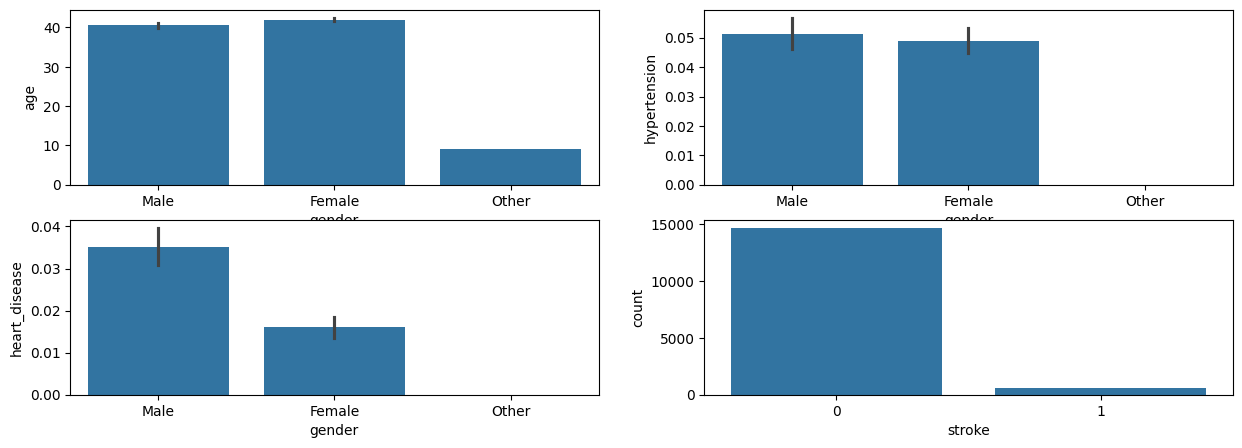

In [ ]:
# barplot statistics for male, female, and nonbinary patients
fig = plt.figure(figsize = (15, 5))
plt.subplot(2,2,1)
sns.barplot(x=train['gender'], y=train['age'])

plt.subplot(2,2,2)
sns.barplot(x=train['gender'], y=train['hypertension'])

plt.subplot(2,2,3)
sns.barplot(x=train['gender'], y=train['heart_disease'])

plt.subplot(2,2,4)
sns.countplot(x=train['stroke'])

## KDE (kernel density estimate)

In [ ]:
# get numerial features of data (id, age, avg glucose level, bmi)
num_cols = test.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('hypertension')
num_cols.remove('heart_disease')

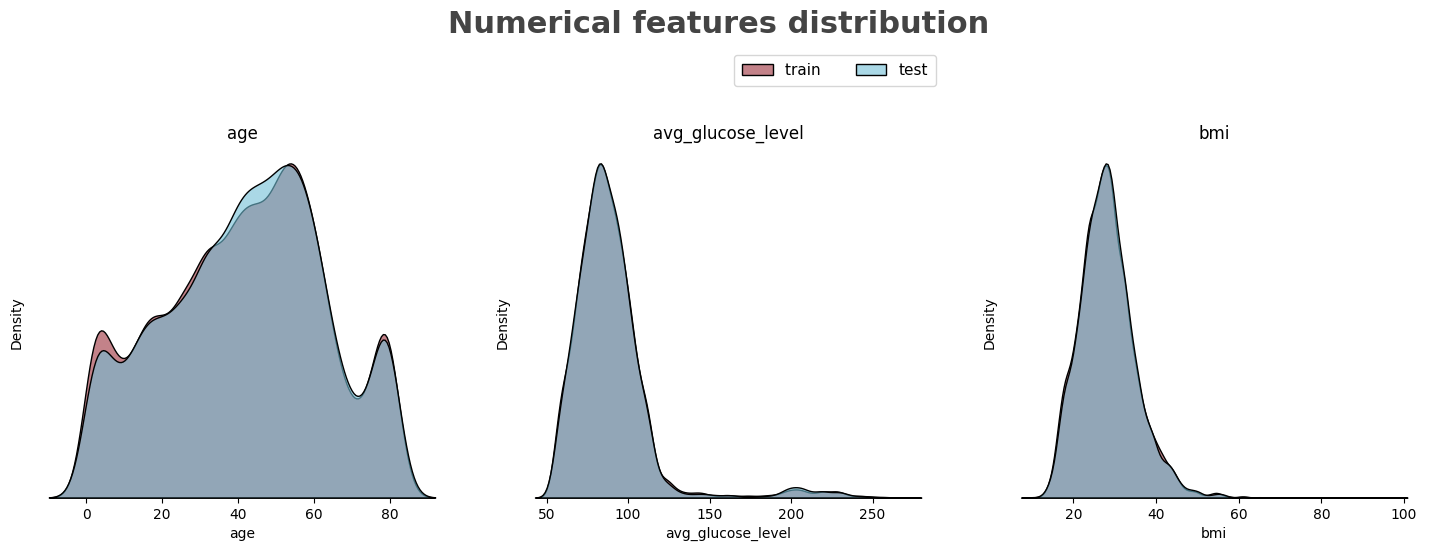

In [ ]:
# display distribution of numerical features for training and testing datasets
fig = plt.figure(figsize = (15, 5))

# for each numerical feature
for i, col in enumerate(num_cols):
  if i==0: # patient id
    continue

  plt.subplot(1,3,i)
  plt.title(col)

  # plot distribution for each feature
  a = sns.kdeplot(train[col], color='#9c2f3b',
                  fill=True, label='train',
                  alpha=0.6, edgecolor='black')
  sns.kdeplot(test[col], color='#72bfd6',
              fill=True, label='test',
              alpha=0.6, edgecolor='black')
  plt.xticks()
  plt.yticks([])

  # hide spines
  for s in ['right', 'top', 'left', 'bottom']:
      a.spines[s].set_visible(False)
  fig.tight_layout(pad=3)

fig.legend(['train ',  'test'], bbox_to_anchor=(0.65, 1.07),
           ncol=3, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.1, 'Numerical features distribution',
            fontweight='bold',size=22, color='#444444', ha='center')
plt.show()

## Distribution by Train vs Test

In [ ]:
# make copy of testing and training datasets for further data analysis
train1 = train.copy()
test1 = test.copy()

# get categorical features
cat_cols = list(set(test.columns) - set(num_cols))

# concatenate the 2 datasets
train1['data'] = 'train'
test1['data'] = 'test'
df = pd.concat([train1, test1])

l = {'train': len(train1),  'test': len(test1)} # length of train and test data

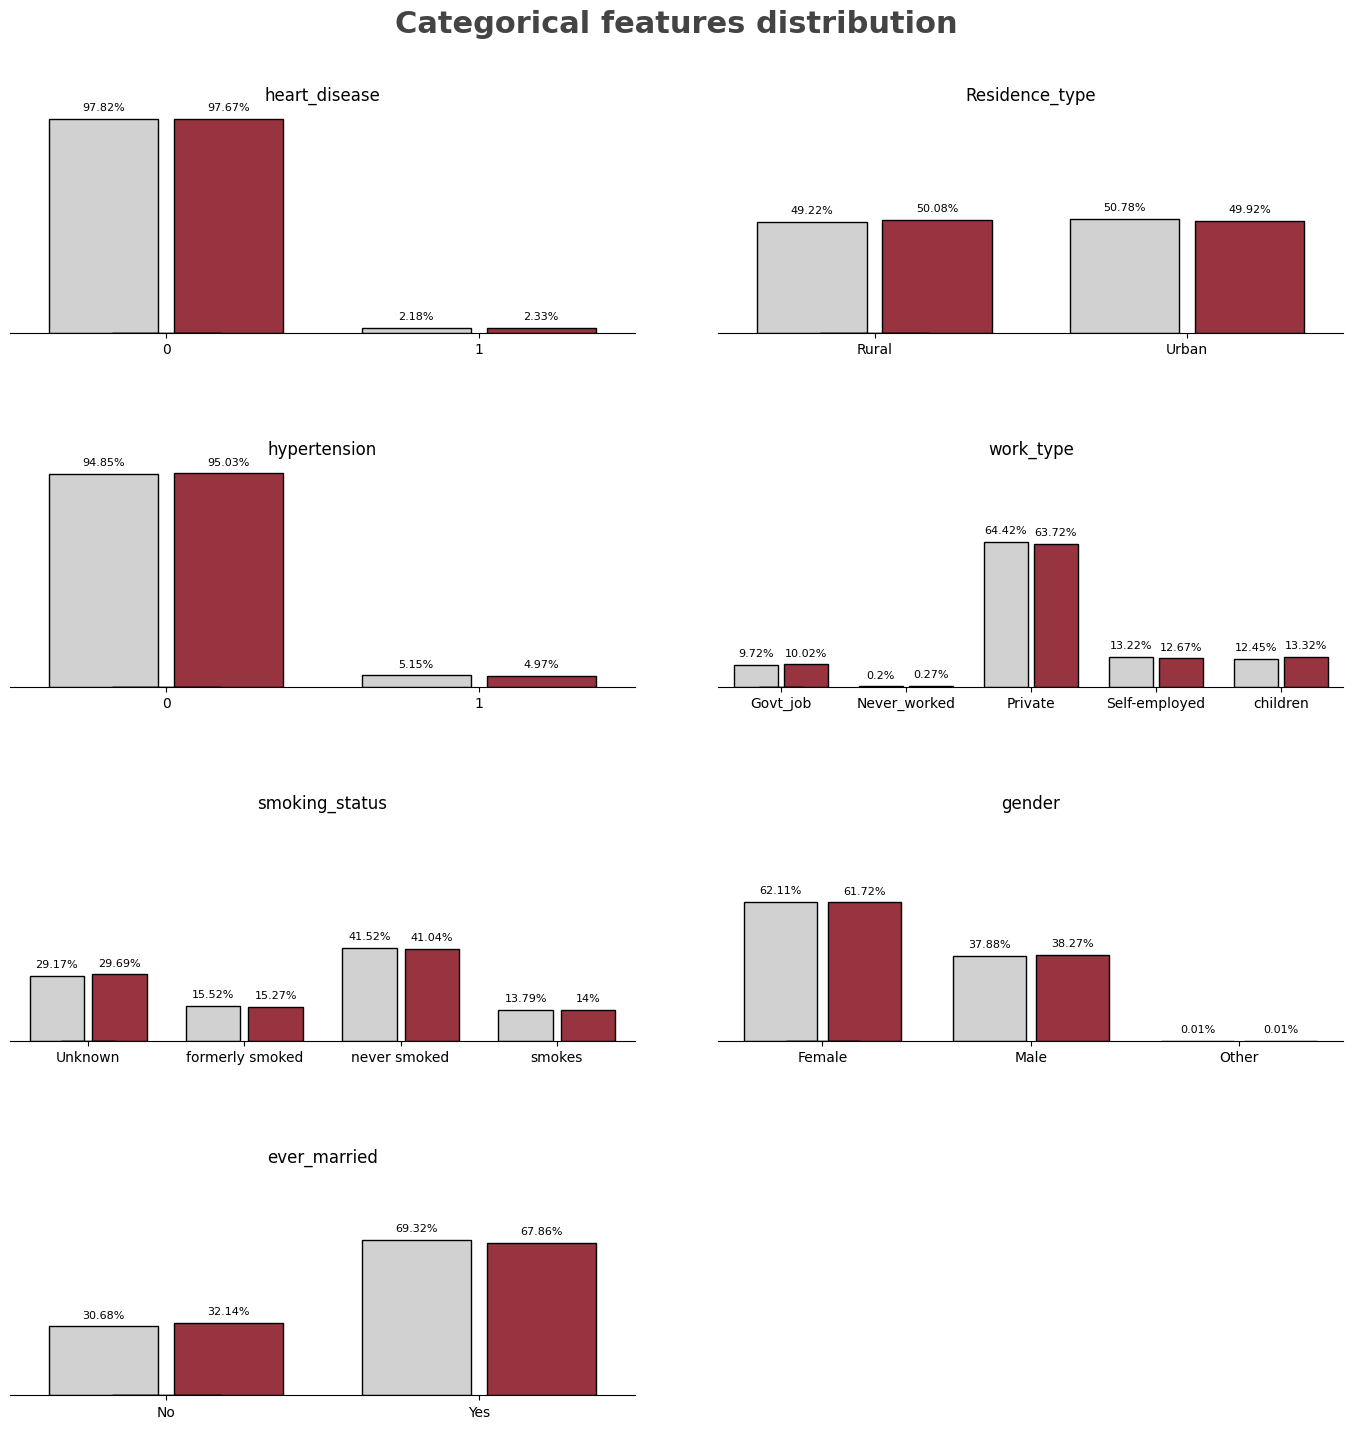

In [ ]:
# plot distribution for each feature for testing and training data sets
# grey: training data, red: testing data

# function to change width of patch
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

fig = plt.figure(figsize=(15, 15))

# for each categorical feature
for i, col in enumerate(cat_cols):

    # regroups the data by type of 'data' (train vs test) and 'col'
    df_plot = df.groupby(['data', col], as_index=False) \
                  ['age'].count().rename({'age': 'count'}, axis=1).reset_index()

    # retrieves and assigns length of data
    df_plot['len_data'] = df_plot['data'].apply(lambda x: l[x])

    # calculate percentages of total length of data
    df_plot['count'] = round(df_plot['count'] / df_plot['len_data'] * 100, 2)

    # plot barplot
    plt.subplot(4,2,i+1)
    plt.title(col)
    a = sns.barplot(data=df_plot, x=col, y='count', hue='data',
                    palette=['#d1d1d1', '#9c2f3b'],
                    linestyle="-", linewidth=1, edgecolor="black",
                    saturation=0.9)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks()
    a.set_yticks([0, 100])
    plt.yticks([])

    # label each bar by percent
    for p in a.patches:
        height = p.get_height()
        if (height>0): # if value in barplot exists, add length percentage on top
          a.annotate(f'{height:g}%', (p.get_x() + p.get_width() / 2, p.get_height()+2),
                   ha='center', va='center', size=8,xytext=(0, 5),
                   textcoords='offset points')

    # hide spines
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)

    # hide legend and change patch width
    a.legend().set_visible(False)
    change_width(a, 0.35)

fig.tight_layout(pad=6)
plt.figtext(0.5, 0.98, 'Categorical features distribution',
            fontweight='bold',size=22, color='#444444', ha='center')
plt.show()

## Distribution of Stroke

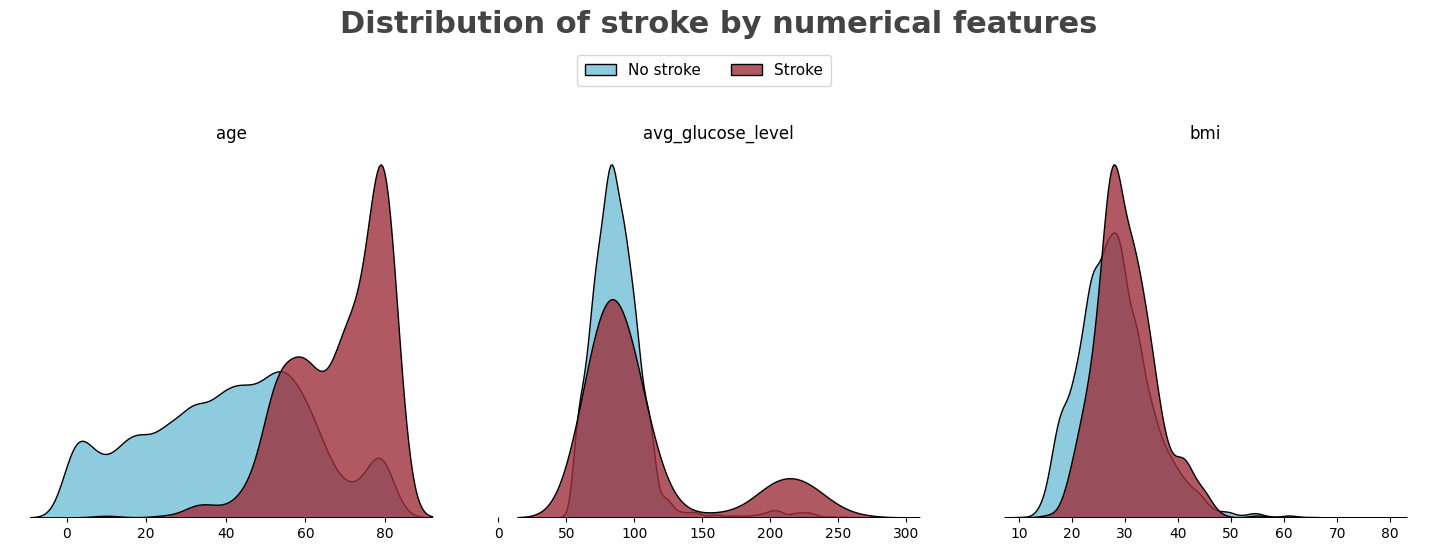

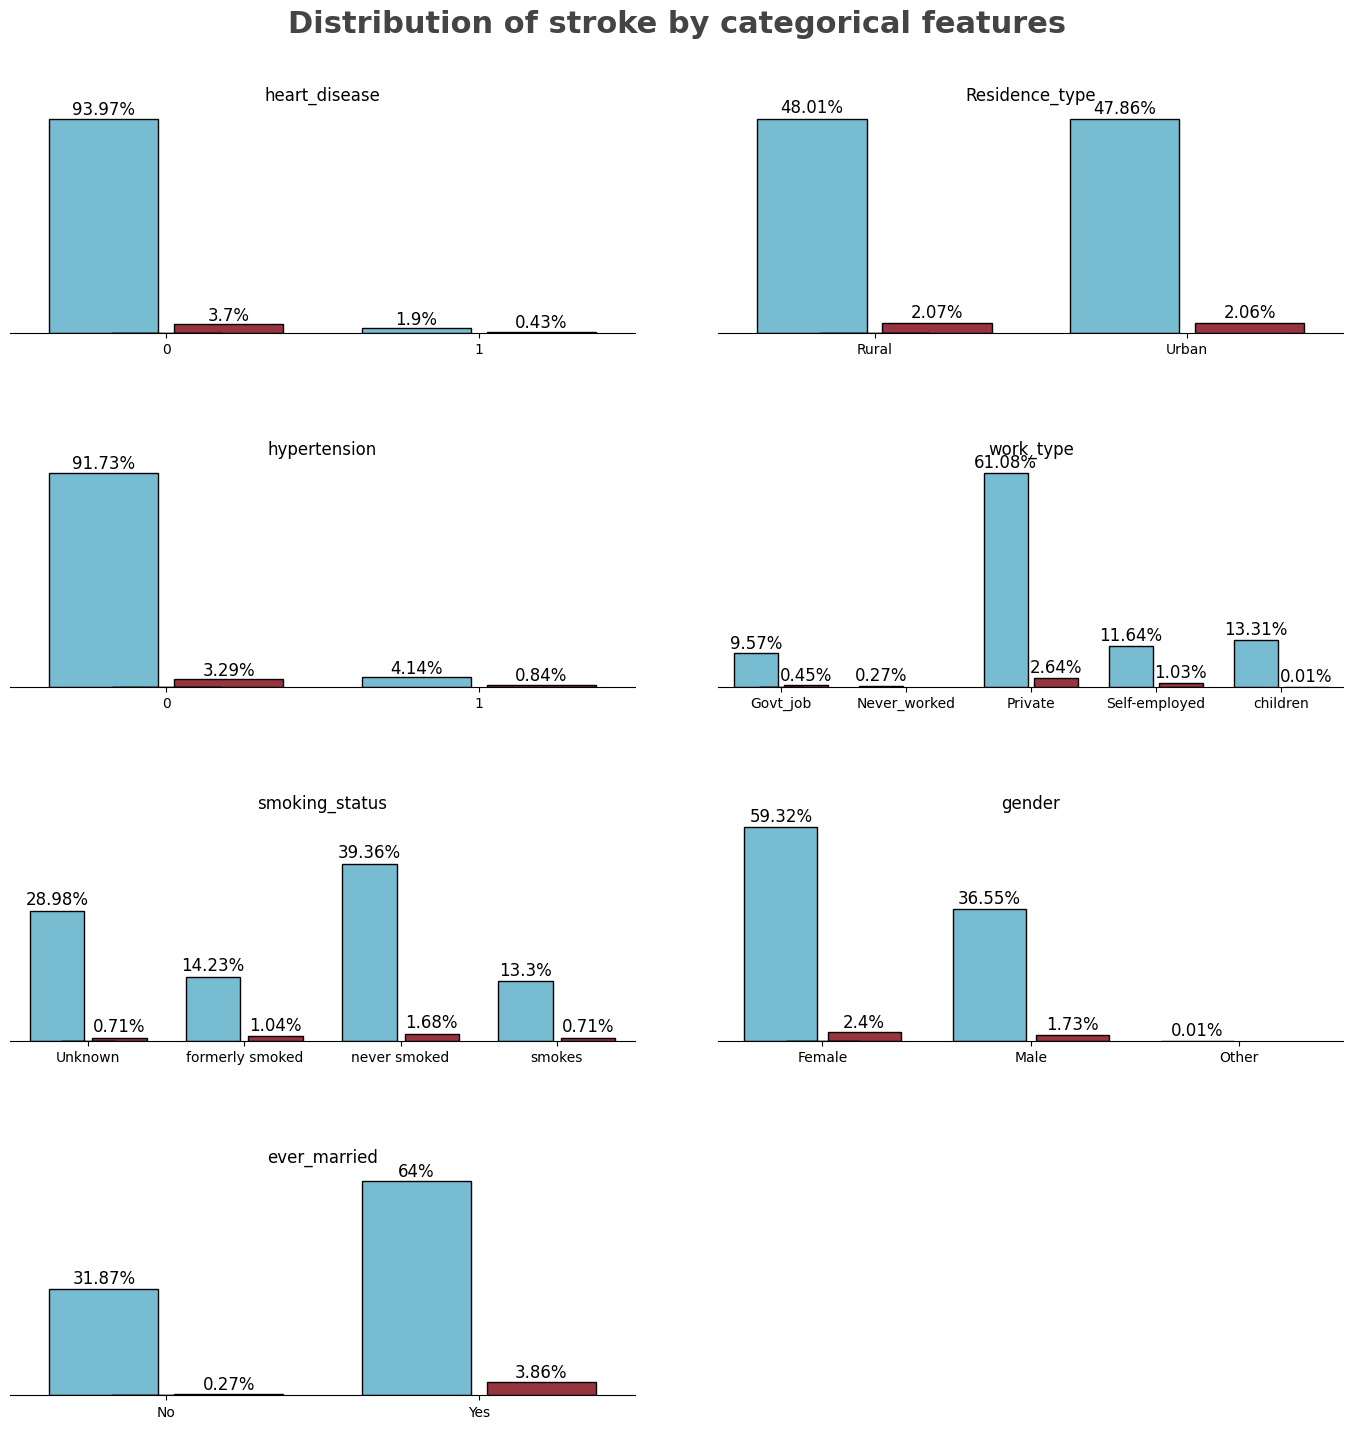

In [ ]:
fig = plt.figure(figsize = (15, 5))

# for each numerical feature
for i, col in enumerate(num_cols):
  if i==0: # skip patient id
    continue
  plt.subplot(1,3,i)
  plt.title(col)

  # plot KDE for training data based on stroke
  a = sns.kdeplot(train1[train1['stroke']==0][col],
                  color='#72bfd6', label='No stroke',
                  fill=True, alpha=0.8, edgecolor='black')
  sns.kdeplot(train1[train1['stroke']==1][col], color='#9c2f3b',
              fill=True, label='Stroke',
              alpha=0.8, edgecolor='black')
  plt.ylabel('')
  plt.xlabel('')
  plt.xticks()
  plt.yticks([])

  # hide spines
  for s in ['right', 'top', 'left', 'bottom']:
      a.spines[s].set_visible(False)

fig.tight_layout(pad=3)
fig.legend(['No stroke', 'Stroke'], bbox_to_anchor=(0.58, 1.07),
           ncol=2, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.1, 'Distribution of stroke by numerical features',
            fontweight='bold', size=22, color='#444444', ha='center')
plt.show()

print()
print()

fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(cat_cols):

    # regroups the data by 'stroke' and 'col'
    df_plot = df.groupby(['stroke', col], as_index=False) \
                  ['age'].count().rename({'age': 'count'}, axis=1)

    # calculate percentages of total length of data
    df_plot['count'] = round(df_plot['count'] / len(train) * 100, 2)

    # plot barplot
    plt.subplot(4,2,i+1)
    plt.title(col)
    a = sns.barplot(data=df_plot, x=col, y='count', hue='stroke',
                    palette=['#72bfd6', '#9c2f3b'],
                    linestyle="-", linewidth=1, edgecolor="black",
                    saturation=0.9)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks()
    a.set_yticks([0, 50])
    plt.yticks([])

    # assign percentages to each bar
    for p in a.patches:
        height = p.get_height()
        if (height>0):
          a.annotate(f'{height:g}%', (p.get_x() + p.get_width() / 2, p.get_height()+1),
                   ha='center', va='center', size=12, xytext=(0, 5),
                   textcoords='offset points')

    # hide spines, legends, change width
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)
    a.legend().set_visible(False)
    change_width(a, 0.35)

fig.tight_layout(pad=6)
plt.figtext(0.5, 0.98, 'Distribution of stroke by categorical features',
            fontweight='bold',size=22, color='#444444', ha='center')
plt.show()

# Data Preprocessing

In [ ]:
# drop id number from data because id number does not impact prediction
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

In [ ]:
# for each feature, return the number of values and the types of unique values
def show_values(df):
    all_cols = df.columns
    feature_name = []
    num_unique_val = []
    name_unique_val = []

    for col in all_cols:
        feature_name.append(col)
        num_unique_val.append(df[col].nunique()) # nunique counts number of unique entries
        name_unique_val.append(df[col].unique())
    return pd.DataFrame({'Feature Name' : feature_name, 'Number of Unique Value': num_unique_val, 'Name of Unique Values': name_unique_val})


In [ ]:
show_values(train)

,Feature Name,Number of Unique Value,Name of Unique Values
0,gender,3,"[Male, Female, Other]"
1,age,106,"[28.0, 33.0, 42.0, 56.0, 24.0, 34.0, 53.0, 78...."
2,hypertension,2,"[0, 1]"
3,heart_disease,2,"[0, 1]"
4,ever_married,2,"[Yes, No]"
5,work_type,5,"[Private, Self-employed, Govt_job, children, N..."
6,Residence_type,2,"[Urban, Rural]"
7,avg_glucose_level,3740,"[79.53, 78.44, 103.0, 64.87, 73.36, 84.35, 88...."
8,bmi,407,"[31.1, 23.9, 40.3, 28.8, 22.2, 25.3, 24.8, 34...."
9,smoking_status,4,"[never smoked, formerly smoked, Unknown, smokes]"


## Data Encoding

In [ ]:
# one hot encoding for gender
enc = OneHotEncoder()
enc_data1 = pd.DataFrame(enc.fit_transform(train[['gender']]).toarray())
enc_data2 = pd.DataFrame(enc.fit_transform(test[['gender']]).toarray())

# join encoded data to train/test
train = train.join(enc_data1[0])
train = train.join(enc_data1[1])
test = test.join(enc_data2[0])
test = test.join(enc_data2[1])

# rename the columns; 0 is female, 1 is male
train = train.rename(columns={0:"female",1:"male"})
test = test.rename(columns={0:"female",1:"male"})

# drop gender
train.drop('gender',axis=1,inplace=True)
test.drop('gender',axis=1,inplace=True)
train

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,female,male
0,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0,0.0,1.0
1,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0,0.0,1.0
2,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0,1.0,0.0
3,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0,0.0,1.0
4,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15299,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0,1.0,0.0
15300,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0,1.0,0.0
15301,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0,1.0,0.0
15302,46.0,0,0,Yes,Private,Rural,101.13,22.5,Unknown,0,0.0,1.0


In [ ]:
# replace categorial data into numbers

# married status is 1 if yes, 0 if no
train['ever_married'].replace(to_replace='Yes', value=1, inplace=True)
train['ever_married'].replace(to_replace='No', value=0, inplace=True)
test['ever_married'].replace(to_replace='Yes', value=1, inplace=True)
test['ever_married'].replace(to_replace='No', value=0, inplace=True)

# residence type is 0 if urban, 1 if rural
train['Residence_type'].replace(to_replace='Urban', value=0, inplace=True)
train['Residence_type'].replace(to_replace='Rural', value=1, inplace=True)
test['Residence_type'].replace(to_replace='Urban', value=0, inplace=True)
test['Residence_type'].replace(to_replace='Rural', value=1, inplace=True)

In [ ]:
# scaling numerical; standardize the data for age, glucose levels, and bmi
numeric_cols = ['age', 'avg_glucose_level','bmi']
for col in numeric_cols:
    train[col] = StandardScaler().fit_transform(train[[col]])
    test[col] = StandardScaler().fit_transform(test[[col]])

In [ ]:
# one hot encoding for smoking status and work type
enc_data3 = pd.DataFrame(enc.fit_transform(train[['smoking_status', 'work_type']]).toarray())
enc_data4 = pd.DataFrame(enc.fit_transform(test[['smoking_status', 'work_type']]).toarray())

# add new encoded columns/data to train
train = train.join(enc_data3[1])
train = train.join(enc_data3[2])
train = train.join(enc_data3[3])

train = train.join(enc_data3[4])
train = train.join(enc_data3[5])
train = train.join(enc_data3[6])
train = train.join(enc_data3[7])

test = test.join(enc_data4[1])
test = test.join(enc_data4[2])
test = test.join(enc_data4[3])

test = test.join(enc_data4[4])
test = test.join(enc_data4[5])
test = test.join(enc_data4[6])
test = test.join(enc_data4[7])

# rename the columns
# 0: unknown smoking status, 8: children
train = train.rename(columns={1:"formerly_smoked",2:"never_smoked",
                              3:"smokes", 4:"govt_job", 5:"never_worked",
                              6:"private_job", 7:"self_employed"})
test = test.rename(columns={1:"formerly_smoked",2:"never_smoked",
                              3:"smokes", 4:"govt_job", 5:"never_worked",
                              6:"private_job", 7:"self_employed"})

# drop smoking status and work type (drop orig, replace with encoded)
train.drop('smoking_status',axis=1,inplace=True)
train.drop('work_type',axis=1,inplace=True)
test.drop('smoking_status',axis=1,inplace=True)
test.drop('work_type',axis=1,inplace=True)

train


,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,female,male,formerly_smoked,never_smoked,smokes,govt_job,never_worked,private_job,self_employed
0,-0.625710,0,0,1,0,-0.373297,0.444397,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.392544,0,0,1,1,-0.416084,-0.626698,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.027154,0,0,1,1,0.547988,1.813018,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.680018,0,0,1,0,-0.948757,0.102242,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.812243,0,0,0,1,-0.615493,0.102242,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,-0.905509,0,0,0,0,-0.644148,-1.281255,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15300,0.213687,1,0,1,0,0.476939,0.593160,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
15301,1.566048,0,0,1,0,-0.052987,-0.284542,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
15302,0.213687,0,0,1,1,0.474584,-0.834966,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
test

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,female,male,formerly_smoked,never_smoked,smokes,govt_job,never_worked,private_job,self_employed
0,0.714762,0,0,1,1,-0.256927,0.765965,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.330966,1,0,1,0,-0.661355,0.038264,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.750052,0,0,0,0,0.560421,-1.298331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.667362,0,0,1,0,-0.770181,1.954048,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.470245,0,0,1,1,0.847148,0.275880,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10199,-0.707246,0,0,0,0,-0.518185,-1.580500,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
10200,0.335560,0,0,1,0,0.529162,-0.229055,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10201,-1.844853,0,0,0,1,0.572770,-1.476543,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10202,-0.517645,0,0,1,0,-0.261943,0.067966,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Feature Engineering

In [ ]:
# create copies of training data for feature engineering
# add respective feature engineered data sets to the copies

# data for epoch A
trainA = train.copy()

# data for epoch B: add age*bmi
trainB = train.copy()
trainB["age*bmi"] = trainB["age"] * trainB["bmi"]

# data for epoch C: add age*avg_glucose_level
trainC = train.copy()
trainC["age*glucose"] = trainC["age"] * trainC["avg_glucose_level"]

# data for epoch D: add bmi*avg_glucose_level
trainD = train.copy()
trainD["bmi*glucose"] = trainD["bmi"] * trainD["avg_glucose_level"]

# data for epoch E: add age*bmi, age*avg_glucose_level, bmi*avg_glucose_level
trainE = train.copy()
trainE["age*bmi"] = trainE["age"] * trainE["bmi"]
trainE["age*glucose"] = trainE["age"] * trainE["avg_glucose_level"]
trainE["bmi*glucose"] = trainE["bmi"] * trainE["avg_glucose_level"]

## Train/Valid/Test data split

In [ ]:
# split training, validation, testing data
def split_data(train):
  # save stroke values into y, drop stroke from x
  y = train['stroke']
  x = train.drop('stroke', axis=1)

  # split training and valid/test data
  x_train, X, y_train, Y = train_test_split(x,y, test_size=0.5, random_state=0, shuffle=True)

  # split validation and test data
  x_valid, x_test, y_valid, y_test = train_test_split(x,y, test_size=0.5, random_state=0, shuffle=True)

  return x_train, y_train, x_valid, y_valid, x_test, y_test


# RF, XGB, LogReg, TabNet Classifier Functions


In [ ]:
# recall metrics for TabNet classifier
class myRecall(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_score):

        np.array(y_true)
        y_score_np = np.array(y_score[:, 1])

        # make score binary (2 classes)
        y_score_np[y_score_np < 0.5] = 0
        y_score_np[y_score_np >= 0.5] = 1

        # get recall score
        rs = recall_score(y_true, y_score_np)
        return rs

In [ ]:
# function to compile tabnet model
# inputs: training data, training labels, validation data, validation labels,
# optimizer type step size, gamma, evaluation metrics, patience, batch size
# output: fitted tabnet model

def compile_TabNet(x_train, y_train, x_test, y_test, optimizer=torch.optim.Adam,
                   step_size=10, gamma=0.9, eval_met='accuracy',
                   patience=60, batch_size=512):

  # define model
  tbnt = TabNetClassifier(optimizer_fn=optimizer,
                          scheduler_params={"step_size":step_size, "gamma":gamma},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,)

  # fit the model
  tbnt.fit(
      x_train.values,y_train.values,
      eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)],
      eval_name=['train', 'test'],
      eval_metric=['auc', eval_met],
      max_epochs=200, patience=60,
      batch_size=batch_size, virtual_batch_size=512,
      num_workers=0,
      weights=1,
      drop_last=False
  )

  return tbnt

In [ ]:
# print evaluation scores for each type of classifier
# inputs: testing data, testing labels, evaluation metric name, eval metric
def print_score(clf, x_test, y_test, eval_name='Accuracy', metric=accuracy_score):
  pred = clf.predict(x_test)
  clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
  print("================================================")
  print(eval_name + f"Score: {metric(y_test, pred) * 100:.2f}%")
  print("_______________________________________________")
  print(f"CLASSIFICATION REPORT:\n{clf_report}")
  print("_______________________________________________")
  print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [ ]:
score=[]

# function to compare logistic regression, random forest, xgb accuracy
def compare_scores(x_test, y_test, rf, xgb, lgr, metric=accuracy_score):

  # random forest score
  rf_test_score = round(metric(y_test, rf.predict(x_test)) * 100,2)
  rf_score = cross_val_score(estimator = rf, X = x_train, y = y_train, cv = 10)
  rf_train_score=round(rf_score.mean()*100,2)

  # xgboost score
  xgb_test_score = round(metric(y_test, xgb.predict(x_test)) * 100,2)
  xgb_score = cross_val_score(estimator = xgb, X = x_train, y = y_train, cv = 10)
  xgb_train_score = round(xgb_score.mean()*100,2)

  # logistic regression score
  log_test_score = round(metric(y_test, lgr.predict(x_test)) * 100,2)
  log_score = cross_val_score(estimator = lgr, X = x_train, y = y_train, cv = 10)
  log_train_score=round(log_score.mean()*100,2)

  test_scores = [rf_test_score, xgb_test_score, log_test_score]
  return test_scores

In [ ]:
# function to build, test, and compare different classifier models
def build_test_models(x_train, y_train, x_valid, y_valid, x_test, y_test, metric=accuracy_score, optimizer=torch.optim.Adam,
                   step_size=10, gamma=0.9, eval_met='accuracy', eval_name = "Accuracy",
                   patience=60, batch_size=512):

  # build and compile tabnet model
  TabNetModel = compile_TabNet(x_train, y_train, x_valid, y_valid,
                               optimizer=optimizer, step_size=step_size,
                               gamma=gamma, eval_met=eval_met,
                               patience=patience, batch_size=batch_size)

  # test tabnet model to predict values
  pred=TabNetModel.predict(x_test.values)

  # print tabnet model report and score
  report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
  score = metric(y_test, pred)
  print("\n\nTest Result for TabNet Classifier: ")
  print("================================================")
  print(eval_name + f"Score: {score * 100:.2f}%")
  print("_______________________________________________")
  print(f"CLASSIFICATION REPORT:\n{report}")
  print("_______________________________________________")
  print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

  # random forest classifier
  rf= RandomForestClassifier() # model
  rf.fit(x_train, y_train) # fit
  print("\n\nTest Result for Random Forest Classifier: ") # print score
  print_score(rf, x_test, y_test, eval_name=eval_name, metric=metric)

  # XGB classifier
  xgb= XGBClassifier() # model
  xgb.fit(x_train, y_train) # fit
  print("\nTest Result for XGB Classifier: ") # print score
  print_score(xgb, x_test, y_test, eval_name=eval_name, metric=metric)

  # logistic regression classifier
  lgr = LogisticRegression() # model
  lgr.fit(x_train, y_train) # fit
  print("\nTest Result for Logistic Regression Classifier: ") # print score
  print_score(lgr, x_test, y_test, eval_name=eval_name, metric=metric)

  # compare the classifiers
  test_scores = compare_scores(x_test, y_test, rf, xgb, lgr, metric=metric)

  # add tabnet scores
  test_scores.append(score*100)

  # scores for each model as data frame
  results_df = pd.DataFrame(data=[['Random Forrest',test_scores[0]],
                                  ['XGB',test_scores[1]],
                                  ["Logistic Regression", test_scores[2]],
                                  ['TabNet', test_scores[3]]],
                            columns=['Model', 'Testing '+ eval_name +' %'])
  results_df.index += 1

  # keep models for later feature importance analysis
  models = [TabNetModel, rf, xgb, lgr]

  print(results_df)

  return test_scores, models


In [ ]:
# plot feature importances
def feature_importances(models, labels, x, y):

  # tabnet architecture feature importance
  ft = pd.DataFrame()
  ft["feature"] = labels
  ft["importance"] = models[0].feature_importances_

  # tabnet sort features
  ft.sort_values(
      by = "importance",
      ascending = True,
      inplace = True
  )
  tbntFT = pd.Series(list(ft["importance"]),list(ft["feature"]))

  # random forest feature importance
  rfFI = pd.Series(models[1].feature_importances_, index=labels)

  # xgboost feature importance
  xgbFitted = models[2].fit(x, y)

  # xgb scale data
  xgbData =[]
  sum_ = sum(xgbFitted.get_booster().get_fscore().values())
  for i in xgbFitted.get_booster().get_fscore().values():
    xgbData.append(i/sum_)
  xgbFI = pd.Series(xgbData, index=xgbFitted.get_booster().get_fscore().keys())

  # logistic regression feature importance
  logFitted = models[3].fit(x, y)
  logFI = pd.Series(abs(logFitted.coef_[0]), index=labels)

  # plot all feature importance plots
  fig, ax = plt.subplots(2,2)
  plt.title("Feature Importances")
  tbntFT.nlargest(20).plot(ax=ax[0,0],kind='barh')
  ax[0,0].set_title("Tabnet")
  rfFI.nlargest(20).plot(ax=ax[0,1],kind='barh')
  ax[0,1].set_title("Random Forest")
  xgbFI.nlargest(20).plot(ax=ax[1,0],kind='barh')
  ax[1,0].set_title("XGBoost")
  logFI.nlargest(20).plot(ax=ax[1,1],kind='barh')
  ax[1,1].set_title("Logistic Regression")

  fig.set_figheight(7)
  fig.set_figwidth(10)
  fig.tight_layout()

  fig.show()


# Build, test, and evaluate models with feature engineered data

## Cohort A

Cohort A: Regular data, Adam optimizer, stepsize 10, gamma 0.9, accuracy evaluation metrics, patience 60, batchsize 512

In [ ]:
# split train, valid, and test data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(trainA)

In [ ]:
# build and test model for each type
test_scores_A, Amodels = build_test_models(x_train, y_train, x_valid, y_valid, x_test, y_test)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61958 | train_auc: 0.81174 | train_accuracy: 0.62284 | test_auc: 0.81174 | test_accuracy: 0.62284 |  0:00:00s
epoch 1  | loss: 0.47508 | train_auc: 0.829   | train_accuracy: 0.63265 | test_auc: 0.829   | test_accuracy: 0.63265 |  0:00:02s
epoch 2  | loss: 0.41012 | train_auc: 0.85053 | train_accuracy: 0.67721 | test_auc: 0.85053 | test_accuracy: 0.67721 |  0:00:02s
epoch 3  | loss: 0.40906 | train_auc: 0.86407 | train_accuracy: 0.69302 | test_auc: 0.86407 | test_accuracy: 0.69302 |  0:00:03s
epoch 4  | loss: 0.38812 | train_auc: 0.88055 | train_accuracy: 0.71824 | test_auc: 0.88055 | test_accuracy: 0.71824 |  0:00:04s
epoch 5  | loss: 0.39051 | train_auc: 0.88216 | train_accuracy: 0.70504 | test_auc: 0.88216 | test_accuracy: 0.70504 |  0:00:04s
epoch 6  | loss: 0.38236 | train_auc: 0.88878 | train_accuracy: 0.70125 | test_auc: 0.88878 | test_accuracy: 0.70125 |  0:00:05s
epoch 7  | loss: 0.37089 | train_auc: 0.89511 | train_accuracy: 0.72256 | test_auc: 0.89511 | tes

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)




Test Result for TabNet Classifier: 
AccuracyScore: 87.79%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.970013    0.140165   0.87794     0.555089      0.934984
recall        0.900396    0.368421   0.87794     0.634408      0.877940
f1-score      0.933909    0.203072   0.87794     0.568490      0.903059
support    7329.000000  323.000000   0.87794  7652.000000   7652.000000
_______________________________________________
Confusion Matrix: 
 [[6599  730]
 [ 204  119]]



Test Result for Random Forest Classifier: 
AccuracyScore: 95.65%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.959417    0.368421  0.956482     0.663919      0.934470
recall        0.996725    0.043344  0.956482     0.520034      0.956482
f1-score      0.977715    0.077562  0.956482     0.527639  

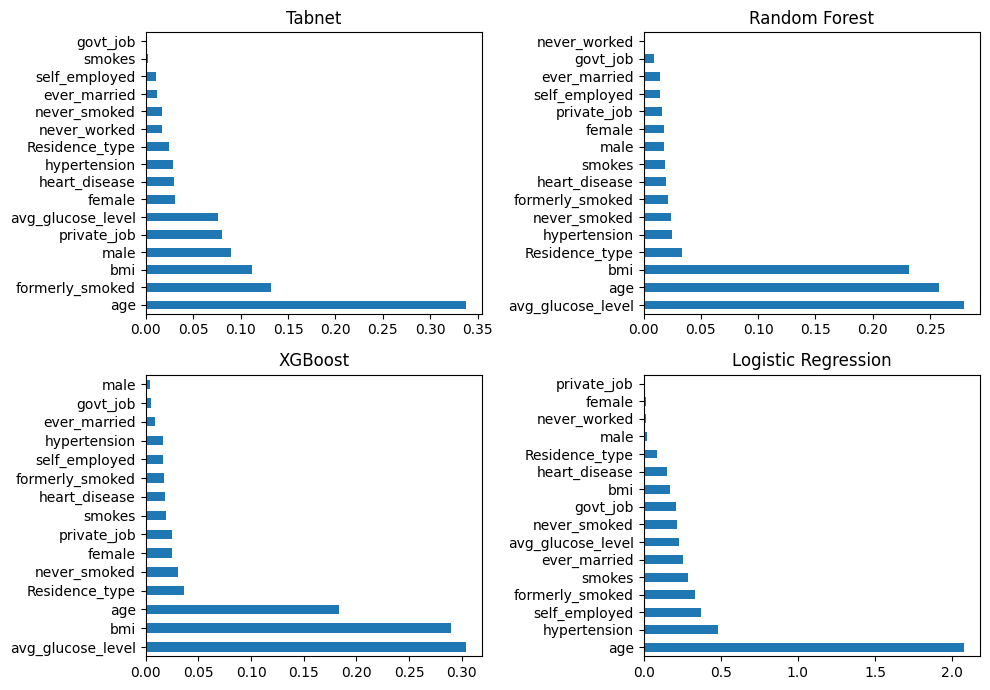

In [ ]:
# visualize feature importances for each model
feature_importances(Amodels, x_train.columns, x_train, y_train)

## Cohort B: age*bmi


Cohort B: age*bmi, Adam optimizer, stepsize 10, gamma 0.9, accuracy evaluation metrics, patience 60, batchsize 512

In [ ]:
# split train, valid, and test data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(trainB)

In [ ]:
# build and test model for each type
test_scores_B, Bmodels = build_test_models(x_train, y_train, x_valid, y_valid, x_test, y_test )

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60947 | train_auc: 0.79038 | train_accuracy: 0.66362 | test_auc: 0.79038 | test_accuracy: 0.66362 |  0:00:00s
epoch 1  | loss: 0.44552 | train_auc: 0.86161 | train_accuracy: 0.62559 | test_auc: 0.86161 | test_accuracy: 0.62559 |  0:00:01s
epoch 2  | loss: 0.39654 | train_auc: 0.86115 | train_accuracy: 0.59422 | test_auc: 0.86115 | test_accuracy: 0.59422 |  0:00:02s
epoch 3  | loss: 0.3977  | train_auc: 0.86728 | train_accuracy: 0.62938 | test_auc: 0.86728 | test_accuracy: 0.62938 |  0:00:03s
epoch 4  | loss: 0.39095 | train_auc: 0.87707 | train_accuracy: 0.69773 | test_auc: 0.87707 | test_accuracy: 0.69773 |  0:00:05s
epoch 5  | loss: 0.38388 | train_auc: 0.89166 | train_accuracy: 0.68897 | test_auc: 0.89166 | test_accuracy: 0.68897 |  0:00:07s
epoch 6  | loss: 0.37337 | train_auc: 0.89525 | train_accuracy: 0.67342 | test_auc: 0.89525 | test_accuracy: 0.67342 |  0:00:08s
epoch 7  | loss: 0.35936 | train_auc: 0.89688 | train_accuracy: 0.67499 | test_auc: 0.89688 | tes

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)




Test Result for TabNet Classifier: 
AccuracyScore: 88.55%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.967676    0.132802   0.88552     0.550239      0.932435
recall        0.910902    0.309598   0.88552     0.610250      0.885520
f1-score      0.938431    0.185874   0.88552     0.562152      0.906665
support    7329.000000  323.000000   0.88552  7652.000000   7652.000000
_______________________________________________
Confusion Matrix: 
 [[6676  653]
 [ 223  100]]



Test Result for Random Forest Classifier: 
AccuracyScore: 95.65%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.959176    0.352941  0.956482     0.656058      0.933586
recall        0.996998    0.037152  0.956482     0.517075      0.956482
f1-score      0.977721    0.067227  0.956482     0.522474  

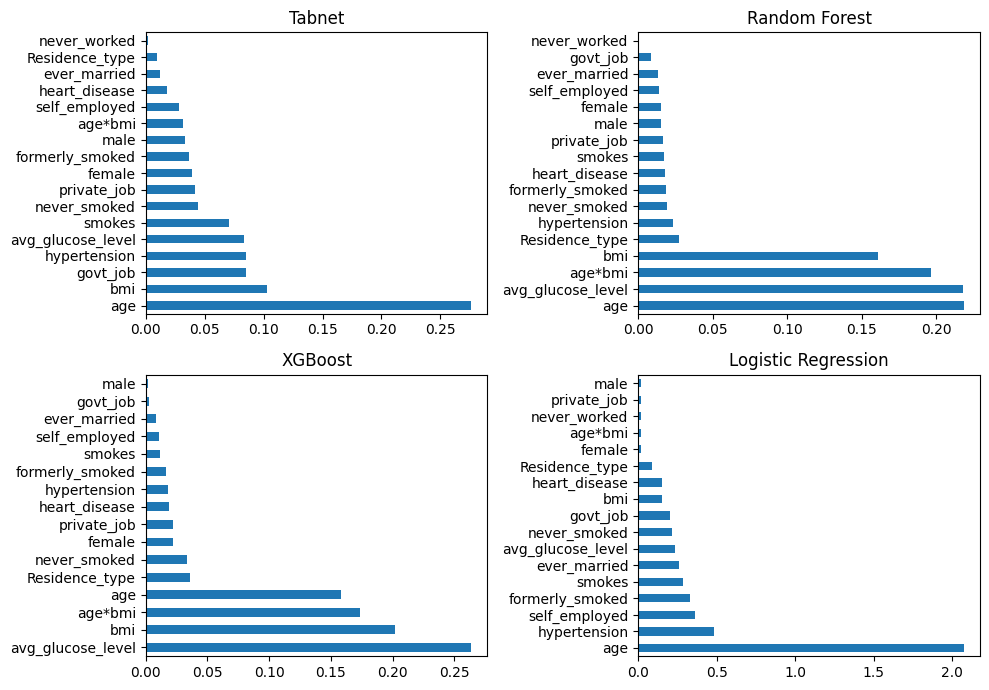

In [ ]:
# visualize feature importances for each model
feature_importances(Bmodels, x_train.columns, x_train, y_train)

## Cohort C: age*avg_glucose_level

Cohort C: age*avg_glucose_level, Adam optimizer, stepsize 10, gamma 0.9, accuracy evaluation metrics, patience 60, batchsize 512

In [ ]:
# split train, valid, and test data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(trainC)

In [ ]:
# build and test model for each type
test_scores_C, Cmodels = build_test_models(x_train, y_train, x_valid, y_valid, x_test, y_test )

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63535 | train_auc: 0.68701 | train_accuracy: 0.63186 | test_auc: 0.68701 | test_accuracy: 0.63186 |  0:00:00s
epoch 1  | loss: 0.47691 | train_auc: 0.80387 | train_accuracy: 0.64467 | test_auc: 0.80387 | test_accuracy: 0.64467 |  0:00:01s
epoch 2  | loss: 0.41914 | train_auc: 0.81873 | train_accuracy: 0.74673 | test_auc: 0.81873 | test_accuracy: 0.74673 |  0:00:02s
epoch 3  | loss: 0.40356 | train_auc: 0.84712 | train_accuracy: 0.76438 | test_auc: 0.84712 | test_accuracy: 0.76438 |  0:00:02s
epoch 4  | loss: 0.39205 | train_auc: 0.86046 | train_accuracy: 0.78515 | test_auc: 0.86046 | test_accuracy: 0.78515 |  0:00:03s
epoch 5  | loss: 0.37466 | train_auc: 0.87282 | train_accuracy: 0.70674 | test_auc: 0.87282 | test_accuracy: 0.70674 |  0:00:04s
epoch 6  | loss: 0.37176 | train_auc: 0.8843  | train_accuracy: 0.68714 | test_auc: 0.8843  | test_accuracy: 0.68714 |  0:00:05s
epoch 7  | loss: 0.37325 | train_auc: 0.88109 | train_accuracy: 0.76059 | test_auc: 0.88109 | tes

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)




Test Result for TabNet Classifier: 
AccuracyScore: 87.70%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.971927    0.150452  0.877026     0.561190      0.937251
recall        0.897530    0.411765  0.877026     0.654648      0.877026
f1-score      0.933248    0.220381  0.877026     0.576815      0.903157
support    7329.000000  323.000000  0.877026  7652.000000   7652.000000
_______________________________________________
Confusion Matrix: 
 [[6578  751]
 [ 190  133]]



Test Result for Random Forest Classifier: 
AccuracyScore: 95.65%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.959658    0.380952  0.956482     0.670305      0.935230
recall        0.996452    0.049536  0.956482     0.522994      0.956482
f1-score      0.977709    0.087671  0.956482     0.532690  

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 Model  Testing Accuracy %
1       Random Forrest           95.650000
2                  XGB           95.190000
3  Logistic Regression           95.770000
4               TabNet           87.702561


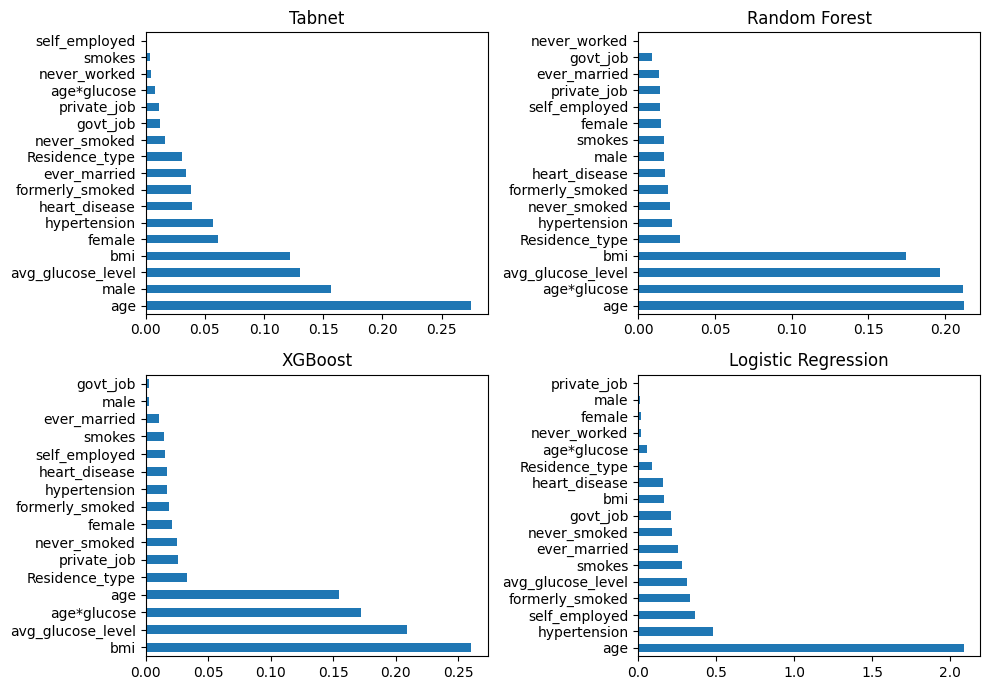

In [ ]:
# visualize feature importances for each model
feature_importances(Cmodels, x_train.columns, x_train, y_train)

## Cohort D: bmi*avg_glucose_level

Cohort D: bmi*avg_glucose_level, Adam optimizer, stepsize 10, gamma 0.9, accuracy evaluation metrics, patience 60, batchsize 512

In [ ]:
# split train, valid, and test data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(trainD)

In [ ]:
# build and test model for each type
test_scores_D, Dmodels = build_test_models(x_train, y_train, x_valid, y_valid, x_test, y_test)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62648 | train_auc: 0.73759 | train_accuracy: 0.47164 | test_auc: 0.73759 | test_accuracy: 0.47164 |  0:00:01s
epoch 1  | loss: 0.43678 | train_auc: 0.81624 | train_accuracy: 0.53973 | test_auc: 0.81624 | test_accuracy: 0.53973 |  0:00:02s
epoch 2  | loss: 0.40161 | train_auc: 0.87392 | train_accuracy: 0.57684 | test_auc: 0.87392 | test_accuracy: 0.57684 |  0:00:03s
epoch 3  | loss: 0.40105 | train_auc: 0.88085 | train_accuracy: 0.64049 | test_auc: 0.88085 | test_accuracy: 0.64049 |  0:00:03s
epoch 4  | loss: 0.39501 | train_auc: 0.8864  | train_accuracy: 0.69315 | test_auc: 0.8864  | test_accuracy: 0.69315 |  0:00:04s
epoch 5  | loss: 0.39422 | train_auc: 0.8883  | train_accuracy: 0.67616 | test_auc: 0.8883  | test_accuracy: 0.67616 |  0:00:05s
epoch 6  | loss: 0.3811  | train_auc: 0.89779 | train_accuracy: 0.71524 | test_auc: 0.89779 | test_accuracy: 0.71524 |  0:00:06s
epoch 7  | loss: 0.37345 | train_auc: 0.89399 | train_accuracy: 0.69354 | test_auc: 0.89399 | tes

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)




Test Result for TabNet Classifier: 
AccuracyScore: 84.89%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.979643    0.157765  0.848928     0.568704      0.944950
recall        0.860145    0.594427  0.848928     0.727286      0.848928
f1-score      0.916013    0.249351  0.848928     0.582682      0.887872
support    7329.000000  323.000000  0.848928  7652.000000   7652.000000
_______________________________________________
Confusion Matrix: 
 [[6304 1025]
 [ 131  192]]



Test Result for Random Forest Classifier: 
AccuracyScore: 95.69%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.958951    0.370370  0.956874     0.664661      0.934106
recall        0.997680    0.030960  0.956874     0.514320      0.956874
f1-score      0.977932    0.057143  0.956874     0.517538  

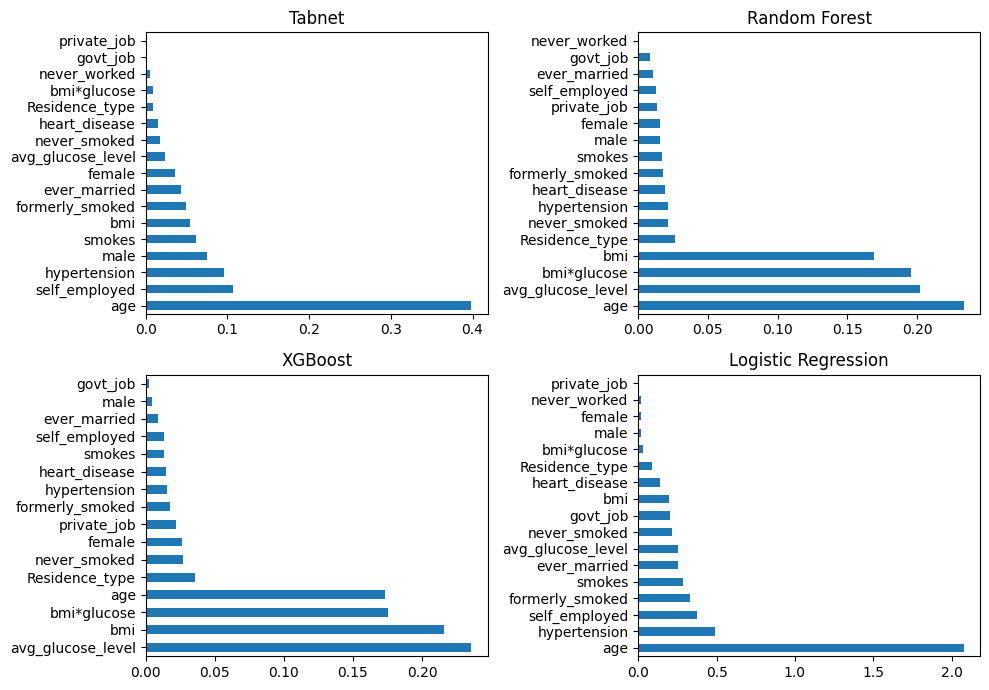

In [ ]:
# visualize feature importances for each model
feature_importances(Dmodels, x_train.columns, x_train, y_train)

## Cohort E: B, C, D combined

Cohort E: age\*bmi, age\*avg_glucose_level, bmi*avg_glucose_level, Adam optimizer, stepsize 10, gamma 0.9, accuracy evaluation metrics, patience 60, batchsize 512

In [ ]:
# split train, valid, and test data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(trainE)

In [ ]:
# build and test model for each type
test_scores_E, Emodels = build_test_models(x_train, y_train, x_valid, y_valid, x_test, y_test)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.664   | train_auc: 0.74429 | train_accuracy: 0.3863  | test_auc: 0.74429 | test_accuracy: 0.3863  |  0:00:00s
epoch 1  | loss: 0.46895 | train_auc: 0.84164 | train_accuracy: 0.5132  | test_auc: 0.84164 | test_accuracy: 0.5132  |  0:00:01s
epoch 2  | loss: 0.42699 | train_auc: 0.85173 | train_accuracy: 0.61487 | test_auc: 0.85173 | test_accuracy: 0.61487 |  0:00:02s
epoch 3  | loss: 0.41459 | train_auc: 0.86515 | train_accuracy: 0.65565 | test_auc: 0.86515 | test_accuracy: 0.65565 |  0:00:02s
epoch 4  | loss: 0.39891 | train_auc: 0.87619 | train_accuracy: 0.66074 | test_auc: 0.87619 | test_accuracy: 0.66074 |  0:00:03s
epoch 5  | loss: 0.39283 | train_auc: 0.8776  | train_accuracy: 0.6546  | test_auc: 0.8776  | test_accuracy: 0.6546  |  0:00:04s
epoch 6  | loss: 0.37208 | train_auc: 0.8761  | train_accuracy: 0.64258 | test_auc: 0.8761  | test_accuracy: 0.64258 |  0:00:04s
epoch 7  | loss: 0.38051 | train_auc: 0.87912 | train_accuracy: 0.69015 | test_auc: 0.87912 | tes

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)




Test Result for TabNet Classifier: 
AccuracyScore: 89.15%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.968971    0.149378  0.891532     0.559174      0.934375
recall        0.916087    0.334365  0.891532     0.625226      0.891532
f1-score      0.941787    0.206501  0.891532     0.574144      0.910750
support    7329.000000  323.000000  0.891532  7652.000000   7652.000000
_______________________________________________
Confusion Matrix: 
 [[6714  615]
 [ 215  108]]



Test Result for Random Forest Classifier: 
AccuracyScore: 95.77%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.959585    0.483871  0.957658     0.721728      0.939505
recall        0.997817    0.046440  0.957658     0.522128      0.957658
f1-score      0.978328    0.084746  0.957658     0.531537  

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

                 Model  Testing Accuracy %
1       Random Forrest           95.770000
2                  XGB           95.140000
3  Logistic Regression           95.750000
4               TabNet           89.153163


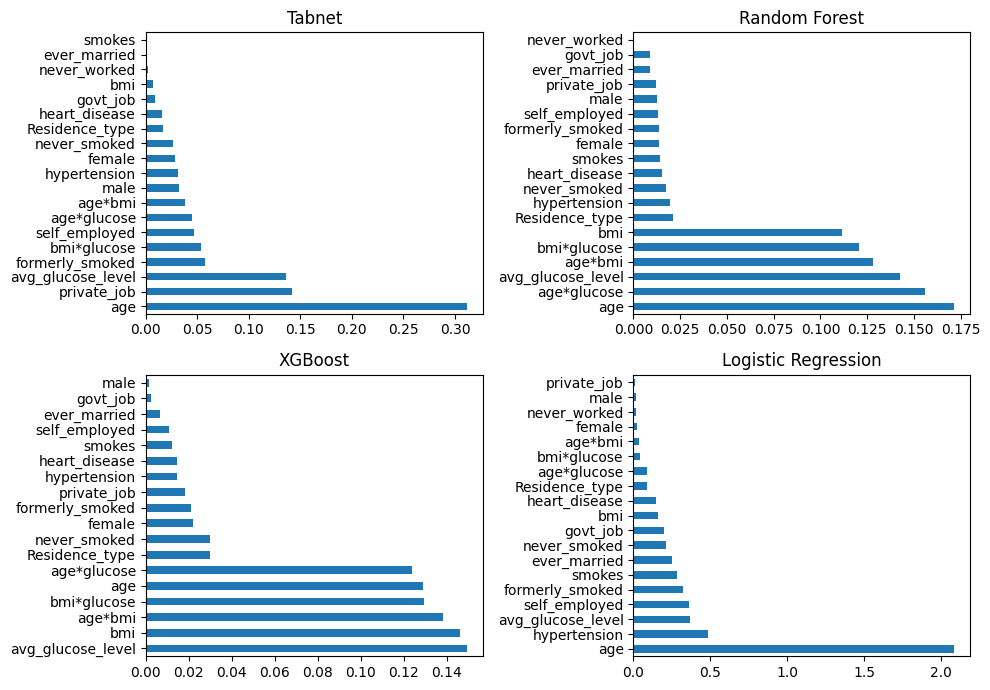

In [ ]:
# visualize feature importances for each model
feature_importances(Emodels, x_train.columns, x_train, y_train)

## Comparisons

In [ ]:
test_scores = [test_scores_A, test_scores_B, test_scores_C, test_scores_D, test_scores_E]

print("\nTest Testing Accuracy for Various Classifier with Different DataSets: ")
print("===============================================================================")

comparison_result = pd.DataFrame(data=[['Random Forrest',test_scores[0][0], test_scores[1][0], test_scores[2][0], test_scores[3][0], test_scores[4][0]],
                                  ['XGB',test_scores[0]
                                  [1], test_scores[1][1], test_scores[2][1], test_scores[3][1], test_scores[4][1]],
                                  ["Logistic Regression", test_scores[0][2], test_scores[1][2], test_scores[2][2], test_scores[3][2], test_scores[4][2]],
                                  ['TabNet', test_scores[0][3], test_scores[1][3], test_scores[2][3], test_scores[3][3], test_scores[4][3]]],
                            columns=['Model', 'Cohort A', 'Cohort B', 'Cohort C', 'Cohort D', 'Cohort E'])
print(comparison_result)
print("===============================================================================")
print("\n A: none \n B: age*bmi \n C: age*avg_glucose_level \n D: bmi*avg_glucose_level \n E: B,C,D together")


Test Testing Accuracy for Various Classifier with Different DataSets: 
                 Model   Cohort A   Cohort B   Cohort C   Cohort D   Cohort E
0       Random Forrest  95.650000  95.650000  95.650000  95.690000  95.770000
1                  XGB  95.280000  95.230000  95.190000  95.260000  95.140000
2  Logistic Regression  95.790000  95.810000  95.770000  95.790000  95.750000
3               TabNet  87.794041  88.552013  87.702561  84.892838  89.153163

 A: none 
 B: age*bmi 
 C: age*avg_glucose_level 
 D: bmi*avg_glucose_level 
 E: B,C,D together


# Build, test, and evaluate Tabnet with various parameters

Using Cohort E data, build and evaluate Tabnet model with various hyperparameters

optimizer=torch.optim.Adam,
step_size=10,
gamma=0.9,
eval_met='accuracy',
patience=60,
batch_size=512

## Cohort 0

Cohort 0: age\*bmi, age\*avg_glucose_level, bmi*avg_glucose_level, Adam optimizer, stepsize 10, gamma 0.9, accuracy evaluation metrics, patience 60, batchsize 512

- No changes made

In [ ]:
# split data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(trainE)

# compile tabnet model
TabNetModel = compile_TabNet(x_train, y_train, x_valid, y_valid,
                             optimizer=torch.optim.Adam, step_size=10, gamma=0.9,
                             eval_met='accuracy', patience=60, batch_size=512)

# test and evaluate model
pred=TabNetModel.predict(x_test.values)
report0 = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
accuracy0 = accuracy_score(y_test, pred)

# print results
print("\n\nTest Result for TabNet Classifier: ")
print("================================================")
print(f"Accuracy Score: {accuracy0 * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{report0}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.664   | train_auc: 0.74429 | train_accuracy: 0.3863  | test_auc: 0.74429 | test_accuracy: 0.3863  |  0:00:01s
epoch 1  | loss: 0.46895 | train_auc: 0.84164 | train_accuracy: 0.5132  | test_auc: 0.84164 | test_accuracy: 0.5132  |  0:00:03s
epoch 2  | loss: 0.42699 | train_auc: 0.85173 | train_accuracy: 0.61487 | test_auc: 0.85173 | test_accuracy: 0.61487 |  0:00:04s
epoch 3  | loss: 0.41459 | train_auc: 0.86515 | train_accuracy: 0.65565 | test_auc: 0.86515 | test_accuracy: 0.65565 |  0:00:05s
epoch 4  | loss: 0.39891 | train_auc: 0.87619 | train_accuracy: 0.66074 | test_auc: 0.87619 | test_accuracy: 0.66074 |  0:00:06s
epoch 5  | loss: 0.39283 | train_auc: 0.8776  | train_accuracy: 0.6546  | test_auc: 0.8776  | test_accuracy: 0.6546  |  0:00:07s
epoch 6  | loss: 0.37208 | train_auc: 0.8761  | train_accuracy: 0.64258 | test_auc: 0.8761  | test_accuracy: 0.64258 |  0:00:08s
epoch 7  | loss: 0.38051 | train_auc: 0.87912 | train_accuracy: 0.69015 | test_auc: 0.87912 | tes

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)




Test Result for TabNet Classifier: 
Accuracy Score: 89.15%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.968971    0.149378  0.891532     0.559174      0.934375
recall        0.916087    0.334365  0.891532     0.625226      0.891532
f1-score      0.941787    0.206501  0.891532     0.574144      0.910750
support    7329.000000  323.000000  0.891532  7652.000000   7652.000000
_______________________________________________
Confusion Matrix: 
 [[6714  615]
 [ 215  108]]



## Cohort 1

Cohort 1: age\*bmi, age\*avg_glucose_level, bmi*avg_glucose_level, SGD optimizer, stepsize 10, gamma 0.9, accuracy evaluation metrics, patience 60, batchsize 512
- Use SGD optimizer

In [ ]:
# split data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(trainE)

# compile tabnet model
TabNetModel = compile_TabNet(x_train, y_train, x_valid, y_valid,
                             optimizer=torch.optim.SGD, step_size=10, gamma=0.9,
                             eval_met='accuracy', patience=60, batch_size=512)

# test and evaluate model
pred=TabNetModel.predict(x_test.values)
report1 = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
accuracy1 = accuracy_score(y_test, pred)

# print results
print("\n\nTest Result for TabNet Classifier: ")
print("================================================")
print(f"Accuracy Score: {accuracy1 * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{report1}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08102 | train_auc: 0.49524 | train_accuracy: 0.48366 | test_auc: 0.49524 | test_accuracy: 0.48366 |  0:00:00s
epoch 1  | loss: 1.02492 | train_auc: 0.52995 | train_accuracy: 0.52143 | test_auc: 0.52995 | test_accuracy: 0.52143 |  0:00:01s
epoch 2  | loss: 0.97134 | train_auc: 0.52667 | train_accuracy: 0.56064 | test_auc: 0.52667 | test_accuracy: 0.56064 |  0:00:02s
epoch 3  | loss: 0.90437 | train_auc: 0.525   | train_accuracy: 0.58037 | test_auc: 0.525   | test_accuracy: 0.58037 |  0:00:02s
epoch 4  | loss: 0.86947 | train_auc: 0.52981 | train_accuracy: 0.59409 | test_auc: 0.52981 | test_accuracy: 0.59409 |  0:00:03s
epoch 5  | loss: 0.84141 | train_auc: 0.52613 | train_accuracy: 0.58076 | test_auc: 0.52613 | test_accuracy: 0.58076 |  0:00:04s
epoch 6  | loss: 0.80383 | train_auc: 0.54716 | train_accuracy: 0.56286 | test_auc: 0.54716 | test_accuracy: 0.56286 |  0:00:04s
epoch 7  | loss: 0.7963  | train_auc: 0.56422 | train_accuracy: 0.57162 | test_auc: 0.56422 | tes

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)




Test Result for TabNet Classifier: 
Accuracy Score: 72.74%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.983761    0.105240  0.727392     0.544500      0.946677
recall        0.727384    0.727554  0.727392     0.727469      0.727392
f1-score      0.836366    0.183881  0.727392     0.510124      0.808824
support    7329.000000  323.000000  0.727392  7652.000000   7652.000000
_______________________________________________
Confusion Matrix: 
 [[5331 1998]
 [  88  235]]



## Cohort 2

Cohort 2: age\*bmi, age\*avg_glucose_level, bmi*avg_glucose_level, Adam optimizer, stepsize 10, gamma 0.9, accuracy evaluation metrics, patience 10, batchsize 256
- Use smaller batchsize and patience

In [ ]:
# split data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(trainE)

# compile tabnet model
TabNetModel = compile_TabNet(x_train, y_train, x_valid, y_valid,
                             optimizer=torch.optim.Adam, step_size=10, gamma=0.9,
                             eval_met='accuracy', patience=10, batch_size=216)

# test and evaluate model
pred=TabNetModel.predict(x_test.values)
report2 = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
accuracy2 = accuracy_score(y_test, pred)

# print results
print("\n\nTest Result for TabNet Classifier: ")
print("================================================")
print(f"Accuracy Score: {accuracy2 * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{report2}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6126  | train_auc: 0.79785 | train_accuracy: 0.64166 | test_auc: 0.79785 | test_accuracy: 0.64166 |  0:00:01s
epoch 1  | loss: 0.45197 | train_auc: 0.80092 | train_accuracy: 0.67303 | test_auc: 0.80092 | test_accuracy: 0.67303 |  0:00:03s
epoch 2  | loss: 0.4162  | train_auc: 0.84567 | train_accuracy: 0.72569 | test_auc: 0.84567 | test_accuracy: 0.72569 |  0:00:04s
epoch 3  | loss: 0.41931 | train_auc: 0.87618 | train_accuracy: 0.74347 | test_auc: 0.87618 | test_accuracy: 0.74347 |  0:00:05s
epoch 4  | loss: 0.40081 | train_auc: 0.89424 | train_accuracy: 0.77169 | test_auc: 0.89424 | test_accuracy: 0.77169 |  0:00:07s
epoch 5  | loss: 0.38489 | train_auc: 0.89303 | train_accuracy: 0.76686 | test_auc: 0.89303 | test_accuracy: 0.76686 |  0:00:08s
epoch 6  | loss: 0.38538 | train_auc: 0.89699 | train_accuracy: 0.80345 | test_auc: 0.89699 | test_accuracy: 0.80345 |  0:00:10s
epoch 7  | loss: 0.38033 | train_auc: 0.91068 | train_accuracy: 0.82449 | test_auc: 0.91068 | tes

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)




Test Result for TabNet Classifier: 
Accuracy Score: 88.30%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.969772    0.144279  0.883037     0.557025      0.934927
recall        0.906126    0.359133  0.883037     0.632630      0.883037
f1-score      0.936870    0.205856  0.883037     0.571363      0.906013
support    7329.000000  323.000000  0.883037  7652.000000   7652.000000
_______________________________________________
Confusion Matrix: 
 [[6641  688]
 [ 207  116]]



## Cohort 3


Cohort 3: age\*bmi, age\*avg_glucose_level, bmi*avg_glucose_level, Adam optimizer, stepsize 5, gamma 0.95, accuracy evaluation metrics, patience 60, batchsize 512
- Use smaller step size and bigger gamma
- lr_scheduler.StepLR: decays learning rate of each parameter group by gamma every step_size epochs

In [ ]:
# split data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(trainE)

# compile tabnet model
TabNetModel = compile_TabNet(x_train, y_train, x_valid, y_valid,
                             optimizer=torch.optim.Adam, step_size=5, gamma=0.95,
                             eval_met='accuracy', patience=60, batch_size=512)

# test and evaluate model
pred=TabNetModel.predict(x_test.values)
report3 = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
accuracy3 = accuracy_score(y_test, pred)

# print results
print("\n\nTest Result for TabNet Classifier: ")
print("================================================")
print(f"Accuracy Score: {accuracy3 * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{report3}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.664   | train_auc: 0.74429 | train_accuracy: 0.3863  | test_auc: 0.74429 | test_accuracy: 0.3863  |  0:00:00s
epoch 1  | loss: 0.46895 | train_auc: 0.84164 | train_accuracy: 0.5132  | test_auc: 0.84164 | test_accuracy: 0.5132  |  0:00:01s
epoch 2  | loss: 0.42699 | train_auc: 0.85173 | train_accuracy: 0.61487 | test_auc: 0.85173 | test_accuracy: 0.61487 |  0:00:02s
epoch 3  | loss: 0.41459 | train_auc: 0.86515 | train_accuracy: 0.65565 | test_auc: 0.86515 | test_accuracy: 0.65565 |  0:00:03s
epoch 4  | loss: 0.39891 | train_auc: 0.87619 | train_accuracy: 0.66074 | test_auc: 0.87619 | test_accuracy: 0.66074 |  0:00:04s
epoch 5  | loss: 0.39127 | train_auc: 0.87784 | train_accuracy: 0.65944 | test_auc: 0.87784 | test_accuracy: 0.65944 |  0:00:05s
epoch 6  | loss: 0.37664 | train_auc: 0.88138 | train_accuracy: 0.65016 | test_auc: 0.88138 | test_accuracy: 0.65016 |  0:00:06s
epoch 7  | loss: 0.38387 | train_auc: 0.8798  | train_accuracy: 0.68074 | test_auc: 0.8798  | tes

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)




Test Result for TabNet Classifier: 
Accuracy Score: 87.95%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.969653    0.139591  0.879509     0.554622      0.934615
recall        0.902442    0.359133  0.879509     0.630788      0.879509
f1-score      0.934841    0.201040  0.879509     0.567940      0.903866
support    7329.000000  323.000000  0.879509  7652.000000   7652.000000
_______________________________________________
Confusion Matrix: 
 [[6614  715]
 [ 207  116]]



## Comparisons

In [ ]:
print("\nTest Testing Accuracy for TabNet with Various Parameters: ")
print("==========================================================")

comparison_result = pd.DataFrame(data=[['TabNet', accuracy0, accuracy1, accuracy2, accuracy3]],
                            columns=['Model','Cohort 0', 'Cohort 1', 'Cohort 2', 'Cohort 3'])
print(comparison_result)
print("==========================================================")
print("\n 0: Original \n 1: SGB optimizer \n 2: Small batchsize \n 3: Small StepSize, Big Gamma")


Test Testing Accuracy for TabNet with Various Parameters: 
    Model  Cohort 0  Cohort 1  Cohort 2  Cohort 3
0  TabNet  0.891532  0.727392  0.883037  0.879509

 0: Original 
 1: SGB optimizer 
 2: Small batchsize 
 3: Small StepSize, Big Gamma
